# Задание 1. A/B–тестирование
## 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

## 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 


In [1]:
# Импортируем необходимые для работы библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pingouin as pg
from scipy.stats import norm
from tqdm.auto import tqdm

plt.style.use('ggplot')

sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize': (12, 6)})

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# Ссылки, по которым хранятся данные
get_file = 'https://getfile.dokpub.com/yandex/get/'
groups_url = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'
groups_add_url = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
active_studs_url = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
checks_url = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'

In [3]:
# Считаем данные
groups = pd.read_csv(get_file + groups_url, sep=';')
groups_add = pd.read_csv(get_file + groups_add_url, sep=',')
active_studs = pd.read_csv(get_file + active_studs_url)
checks = pd.read_csv(get_file + checks_url, sep=';')

Посмотрим на имеющиеся данные, исследуем на дубликаты и пропущенные значения

In [4]:
# Для того, чтобы избавиться от повторяющихся блоков команд для каждого из датасетов,
# соберу проверку на дубликаты и пропуски в одну функцию.
# В ней же и посмотрю на размер датаметов
def info (df):
    duplicated = df.duplicated().sum()  # дубликаты
    null = df.isna().sum().sum() # пропуски
    shape = df.shape[0] # число записей в датасете
    name = [x for x in globals() if globals()[x] is df][0]
    text = '\033[1m{df}\033[0m \n duplicates: {duplicated}; \n null: {null}; \n shape: {shape}.' \
            .format(df=name, duplicated=duplicated, null=null, shape=shape)
    return print(text)

In [5]:
# Датасет с информацией о том, к какой из групп принадлежит каждый из пользователей
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [6]:
groups.dtypes

id      int64
grp    object
dtype: object

In [7]:
# Посмотим разделение пользователей по группам
groups.grp.value_counts(normalize=True)

B    0.803032
A    0.196968
Name: grp, dtype: float64

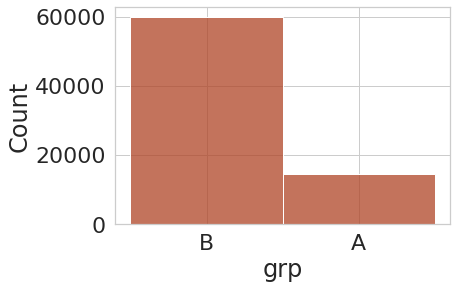

In [8]:
# Визуализируем разбиение
plt.figure(figsize=(6,4))
sns.histplot(groups.grp, color = '#AF4425')

Получается, целевая группа примерно в 4 раза больше контрольной

In [9]:
# Вызовем функцию с информацией о датасете
info(groups)

groups 
 duplicates: 0; 
 null: 0; 
 shape: 74484.


Датасет **groups** содержит в себе 74484 записи, без пропусков и дубликатов. Из данных видно, что пользователей в контрольной группе примерно в 4 раза меньше, чем в целевой.

In [10]:
# Пользователи, которые зашли на платформу в дни эксперимента
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [11]:
active_studs.dtypes

student_id    int64
dtype: object

In [12]:
# Вызовем функцию с информацией
info(active_studs)

active_studs 
 duplicates: 0; 
 null: 0; 
 shape: 8341.


Датасет **active_studs** содержит 8341 записи. Следовательно, из 74484 пользователей из первых двух датасетов в дни проведения эксперимента зашло около 11% пользователей.

In [13]:
# Оплата пользователей в дни эксперимента
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [14]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [15]:
# Информация о датасете
info(checks)

checks 
 duplicates: 0; 
 null: 0; 
 shape: 541.


In [16]:
# Дополнительно посмотрю информацию о том, повторяются ли id пользователей
checks.duplicated(subset='student_id').sum()

0

Датасет **checks** содержит 541 запись об оплате пользователями. Записи не дублируются, причем каждый id встречается только один раз. Значит, либо каждый из пользователей заходил на платформу и/или что-то покупал по одному разу, либо в датасете представлена информация о суммарной покупке для каждого из пользователей. Из данных видим, что из всех зашедших на платформу покупку совершили только около 7% пользователей

Для дальнейшей работы с данными приведем названия столбцов датасетов к одному виду:

In [17]:
active_studs.rename(columns={'student_id': 'id'}, inplace=True)
checks.rename(columns={'student_id': 'id'}, inplace=True)

Создадим новый датасет, в который добавим тех пользователей, которые заходили на платформу во время эксперимента, а также информацию о том, к какой группе они относятся

In [18]:
active_users = active_studs.merge(groups, how='left', on='id')
active_users.head()

,id,grp
0,581585,A
1,5723133,NaN
2,3276743,B
3,4238589,A
4,4475369,B


In [19]:
active_users.isna().sum()

id      0
grp    13
dtype: int64

Получается, 13 пользователей из тех, кто заходил на платформу, не был отнесен ни в какую из групп. Уберем эти данные из анализа

In [20]:
active_users.dropna(inplace=True)
active_users.isna().sum(), active_users.shape

(id     0
 grp    0
 dtype: int64,
 (8328, 2))

Итак, у нас остается 8328 записей, которые теперь разделим на два датасета по группам, предварительно присоединив информацию об оплатах и оставив только тех пользователей, которые эту оплату произвели

In [21]:
all_data = checks.merge(groups, how='left', on='id')
all_data.head()

,id,rev,grp
0,1627,990.0,A
1,3185,690.0,B
2,25973,690.0,B
3,26280,690.0,B
4,100300,990.0,B


In [22]:
all_data.shape

(541, 3)

In [23]:
all_data.isna().sum()

id     0
rev    0
grp    1
dtype: int64

Снова есть пропущенное значение, убираем его

In [24]:
all_data.dropna(inplace=True)
all_data.isna().sum(), all_data.shape

(id     0
 rev    0
 grp    0
 dtype: int64,
 (540, 3))

Оплат осталось 540, присоединим к ним информацию о том, кто их делал

In [25]:
result = active_users.merge(all_data, on=['id', 'grp'], how='left')
result.head()

,id,grp,rev
0,581585,A,NaN
1,3276743,B,NaN
2,4238589,A,NaN
3,4475369,B,NaN
4,5481015,B,NaN


In [26]:
# Проверим, все ли данные на месте
result.count()

id     8328
grp    8328
rev     391
dtype: int64

На этот раз видим, что оплат осталось меньше, чем было. Видимо, каких-то id в active_users не было. Но эти данные об оплатах понадобятся нам для анализа, поэтому добавим их обратно

In [27]:
active_users_new = active_users.merge(all_data, how='outer', on=['id', 'grp'])
active_users_new.head()

,id,grp,rev
0,581585,A,NaN
1,3276743,B,NaN
2,4238589,A,NaN
3,4475369,B,NaN
4,5481015,B,NaN


In [28]:
active_users_new.count()

id     8477
grp    8477
rev     540
dtype: int64

Оплаты вернулись, теперь можно разбивать на группы:

In [29]:
# Контрольная группа
group_A = active_users_new[active_users_new.grp == 'A']
# Тестовая группа
group_B = active_users_new[active_users_new.grp == 'B']

In [30]:
# Проверяем:
group_A.shape[0] + group_B.shape[0] == active_users_new.shape[0]

True

Итак, познакомились с данными и привели их к тому виду, с которым будет удобно работать. Теперь посмотрим на описательные характеристики тестовой и контрольной групп

In [31]:
# Рассчитаем описательные характеристики
group_A_desc = group_A.rev.describe()
group_B_desc = group_B.rev.describe()
statistics = pd.DataFrame([group_A_desc, group_B_desc, group_B_desc - group_A_desc], 
                         index=['control A', 'test B', 'difference B - A']) # построим таблицу с результатами 

statistics

,count,mean,std,min,25%,50%,75%,max
control A,107.0,860.710280,815.893445,199.0,290.0,690.0,990.0,3660.0
test B,433.0,1106.997699,741.714026,199.0,398.0,880.0,1900.0,4650.0
difference B - A,326.0,246.287418,-74.179419,0.0,108.0,190.0,910.0,990.0


Функция describe значения NaN не учитывает, поэтому данная статистика верна для платящих пользователей. Из таблицы видно, что отличия в группах есть - и в среднем значении, и в медианном. Остается понять, являются ли эти различия значимыми

### Проверим, есть ли статистически значимые отличия в группах

Чтобы бизнесу принять решение о том, стоит ли вводить новую механику оплаты, необходимо сравнить в группах следующие метрики:
- **Средний чек**
- **Конверсия в покупку CR**

Эти метрики напрямую влияют на бизнес и могут быть рассчитаны из имеющихся данных, поэтому остановлюсь на них.

Гипотезы: 
- **Н0**: метрики в группах не отличаюся, 
- **Н1**: метрики отличаются.  

### 1. Средний чек

In [32]:
# Посмотрим на средние значения чеков для платящих пользователей
table = active_users_new.groupby('grp') \
                        .agg({'rev': 'mean'})
table

,rev
grp,
A,860.710280
B,1106.997699


Средние значения в группах отличаются. На первый взгляд кажется, что отличаются сильно. Проверим это статистически.

Посмотрим на распределение сумм покупок на гистограмме:

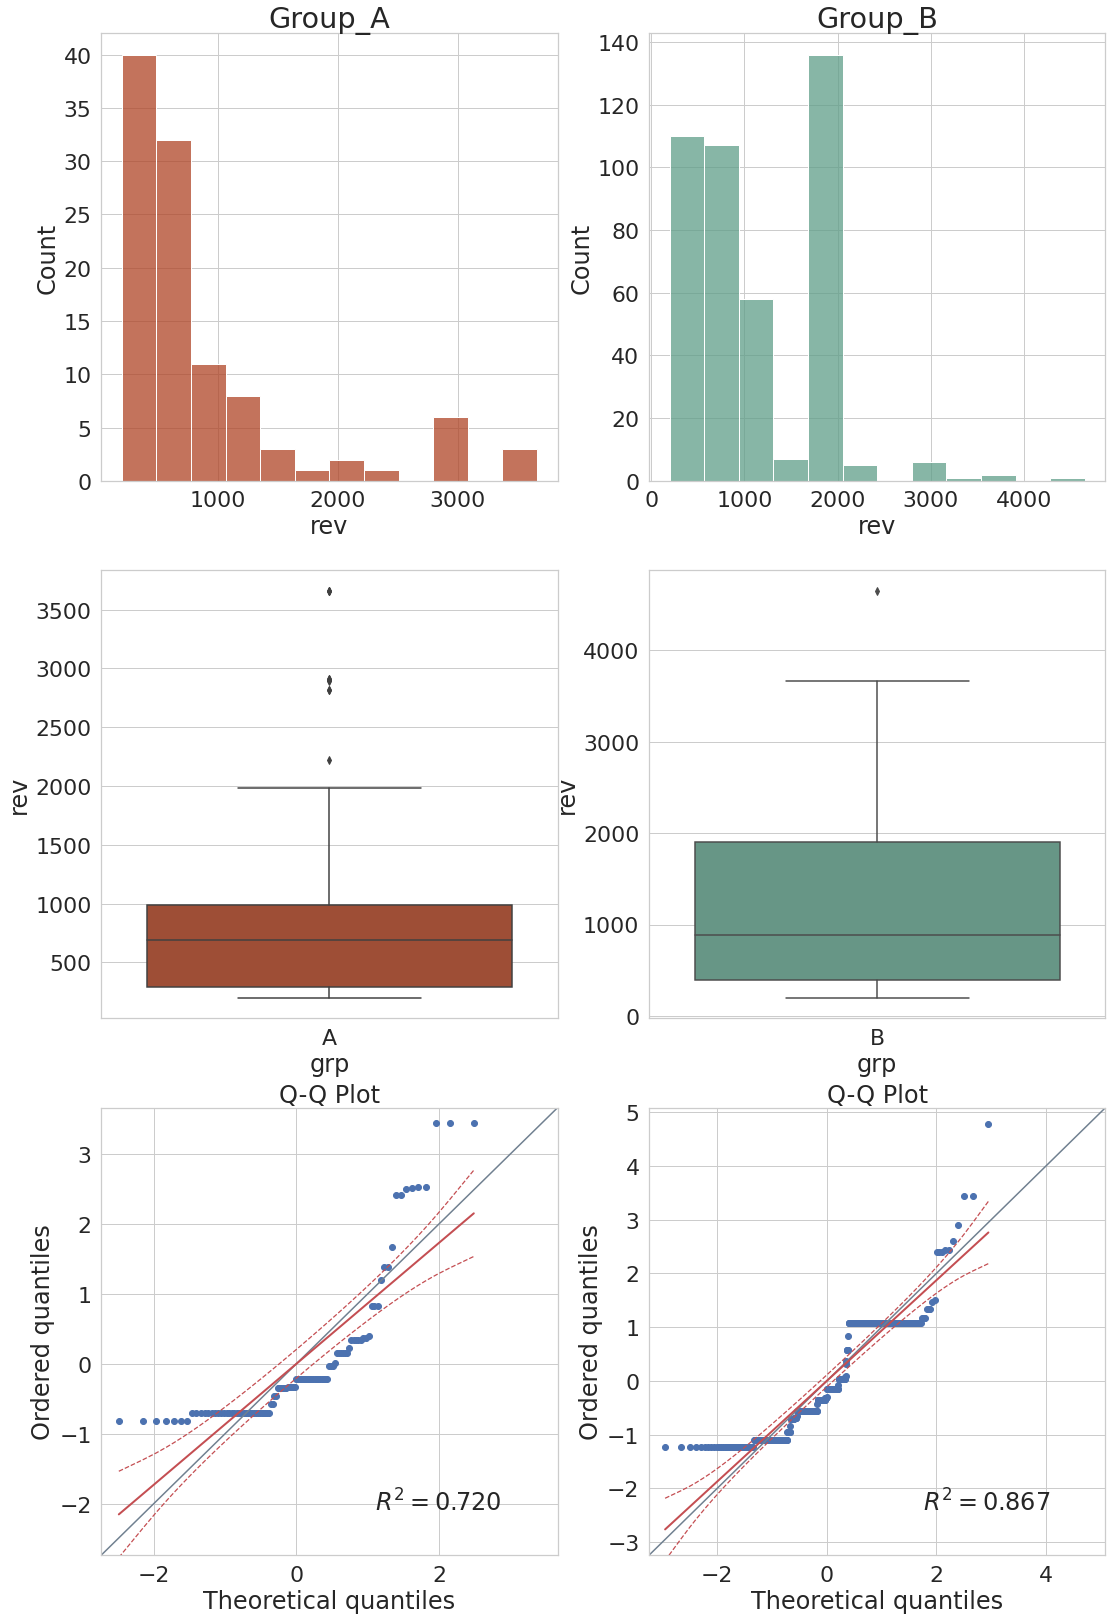

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 28))
ax = axes.flatten()

sns.histplot(group_A, x='rev', ax=ax[0], color='#AF4425')
ax[0].set_title('Group_A', fontsize='large')

sns.boxplot(data=group_A, x='grp', y='rev', ax=ax[2], color='#AF4425')

sns.histplot(group_B, x='rev', ax=ax[1], color='#5F9E88')
ax[1].set_title('Group_B', fontsize='large')

sns.boxplot(data=group_B, x='grp', y='rev', ax=ax[3], color='#5F9E88')

pg.qqplot(group_A.rev, ax=ax[4])

pg.qqplot(group_B.rev, ax=ax[5])

plt.show()

В группе В видим большое количество чеков с суммой около 2000. Также видим, что в целом форма распределений групп А и В похожа друг на друга за исключением этих чеков. Значения выше в тестовой группе из-за того, что сама группа примерно в 4 раза больше контрольной. 

Также хорошо видно, что данные не являются нормально распределенными. Проверим это так же при помощи теста Шапиро-Уилка, уровень значимости *alpha = 0.05*:
- **Н0**: распределение нормально;
- **Н1**: распределение ненормально.



In [34]:
scipy.stats.shapiro(group_A.rev.dropna())

ShapiroResult(statistic=0.7196124196052551, pvalue=5.321687643507211e-13)

In [35]:
scipy.stats.shapiro(group_B.rev.dropna())

ShapiroResult(statistic=0.867313027381897, pvalue=9.542798088039443e-19)

Как и предполагалось, нулевую гипотезу о нормальности отвергаем для обеих групп

Посмотрим, где аномально много чеков:

In [36]:
group_B.rev.value_counts().head()

1900.0000    96
290.0000     63
690.0000     59
199.0000     39
1900.0001    36
Name: rev, dtype: int64

Эта сумма, которая встречается аномально много раз, - 1900. Возможно, новая механика оплаты - это введение регулярного платежа/ подписки. 

В обеих группах предположение о нормальности отвергается. Следовательно, мы имеем дело с двумя независимыми группами, количественными ненормально распределенными данными. Для оценки различий в средних чеках воспользуемся бутстрапом

In [37]:
def get_bootstrap(
        data_column_1,  # числовые значения первой выборки
        data_column_2,  # числовые значения второй выборки
        boot_it=1000,  # количество бутстрэп-подвыборок
        statistic=np.mean,  # интересующая нас статистика
        bootstrap_conf_level=0.95  # уровень значимости
):  
    
    boot_len = max([len(data_column_1), len(data_column_2)])  # вычсиляем, в какой выборке больше всего наблюдений 
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки в кол-ве элементов, равным макс. кол-ву наблюдений
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику к разнице значений
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    # расчет доверительных интервалов    
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    # расчет p-value
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50, color='#5F9E88')
    
    plt.style.use('seaborn-bright')
    plt.vlines(ci, ymin=0, ymax=3000, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}



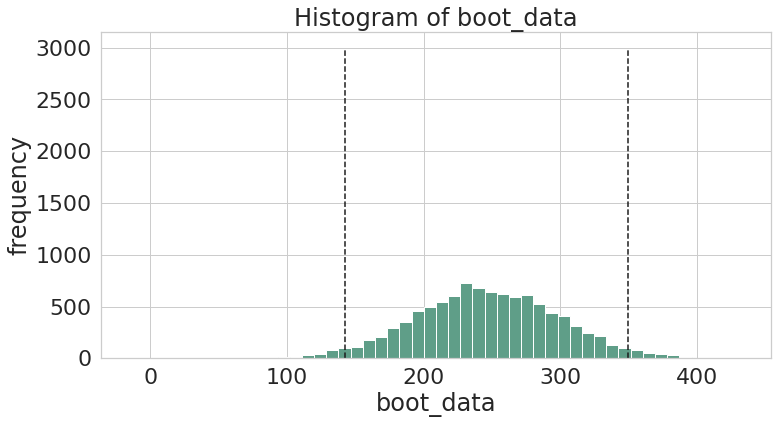

{'ci':                 0
 0.025  142.865423
 0.975  349.576972,
 'p_value': 2.5459282850339237e-06}

In [38]:
# средний чек
bootstrap_mean = get_bootstrap(group_B.dropna().rev, group_A.dropna().rev, boot_it=10000, statistic=np.mean)
bootstrap_mean

P-value < 0.05, а значит отклоняем нулевую гипотезу о равенстве средних. **Средние чеки значимо отличаются**

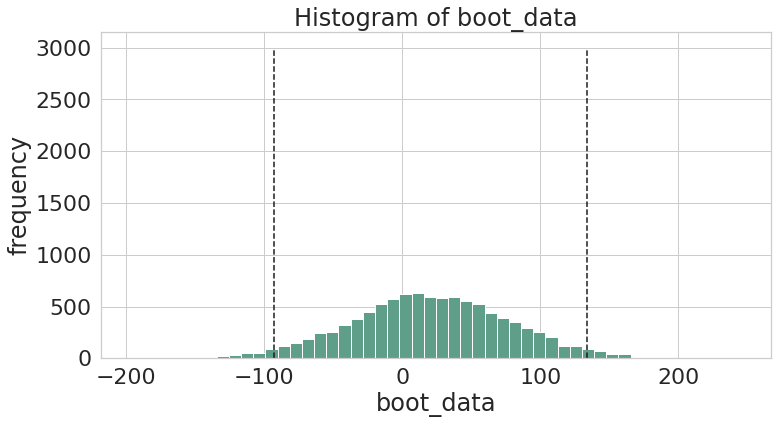

{'ci':                 0
 0.025  -93.147765
 0.975  133.523898,
 'p_value': 0.72765924099104}

In [39]:
# уберем из анализа чеки на сумму 1900:
bootstrap_mean_new = get_bootstrap(group_B[group_B.rev != 1900].dropna().rev, group_A[group_A.rev != 1900].dropna().rev, boot_it=10000, statistic=np.mean)
bootstrap_mean_new

Как и предполагалось, именно эти чеки вносят значимую разницу между группами. При исключении из рассмотрения чеков = 1900, значимых различий уже нет, p-value значительно больше 0.05.

**Вывод: в тестовой группе зафиксировано статистически значимое увеличение среднего чека. Это, вероятнее всего, связано с добавлением опции подписки на регулярный платеж (1900). Если эти платежи не учитывать, средние чеки не различаются значимо**

### 2. Конверсия в покупку

Для данной метрики нам важен тот факт, совершил ли пользователь покупку или нет, поэтому наш тип данных (да/нет) - качественный.
Группы по-прежнему две, они независимы. Для проверки статистической значимости различий в группах воспользуемся критерием **хи-квадрат**.
Соответствующие гипотезы:
- **Н0** - конверсия не изменилась, 
- **Н1** - конверсия изменилась. 

Решение принимаем в соответствии с **alpha = 0.05**

In [40]:
# Добавим в датасет active_users_new  логический столбец с информацией о том, совершил пользователь покупку или нет
active_users_new['purchase_completed'] = active_users_new.loc[:, 'rev'].apply(lambda x: 1 if x > 0 else 0)
active_users_new.sample(10)

,id,grp,rev,purchase_completed
3086,271137,B,NaN,0
4231,1417830,A,NaN,0
1087,3312021,B,NaN,0
5161,5599500,B,NaN,0
1905,1440515,B,NaN,0
7293,1117553,A,NaN,0
5263,4367888,B,NaN,0
3077,4946629,B,NaN,0
7799,857005,B,NaN,0
4695,741345,B,NaN,0


In [41]:
# Теперь создадим частотную таблицу со следующими значениями: "А - покупка", "А - нет покупки", "В - покупка", "В - нет покупки"
table_chi2 = pd.crosstab(active_users_new.grp, active_users_new.purchase_completed)
table_chi2

purchase_completed,0,1
grp,,
A,1457,107
B,6480,433


In [42]:
# Теперь применим к полученным данным критерий хи-квадрат
stat, pvalue, dof, exp = scipy.stats.chi2_contingency(table_chi2)
stat, pvalue

(0.6204959154128902, 0.4308630604023529)

В результате теста получили p-value > 0.05, что не позволяет отвергнуть гипотезу Н0. Таким образом, статистических различий в группах не выявлено, конверсия в покупку для новой механики оплаты значимо не изменилась.

### Выводы:
1. В данных есть признак того, что новый **механизм оплаты - это введение регулярного платежа**. 
2. Медианные и средние чеки в группах значимо различаются, в тестовой группе средний и медианный чеки выше.
3. **Конверсия в покупку не изменилась статистически значимо**.
4. **Новую механику стоит запускать на всех пользователей**, так как значимое увеличение среднего и медианного чека - это важный результат для бизнеса.

# Задание 2. SQL

## 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

### 2.1.2 Задача

Таблица **peas**:
    
| **Название атрибута**  | **Тип атрибута**  | **Смысловое значение**  |
|:-:|:-:|:--|
|  st_id | int  | ID ученика |
| timest | timestamp  | Время решения карточки |
| correct | bool | Правильно ли решена горошина? |
| subject | text | Дисциплина, в которой находится горошина |

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.


In [ ]:
SELECT   count(p.st_id) as dilligent_students  -- назовем итоговый результат 
    FROM (
    
        SELECT   
                 p.st_id,
                 toDayOfYear(p.timest), -- из даты извлечем дни, чтобы выделить март
                 toHour(p.timest),   -- извлечем часы для поиска тех студентов, кто решил от 20 задач в час
                 SUM(p.correct) as peas_number

        FROM     
                 peas AS p

        WHERE    
                 timest >= '2020-03-01' AND timest < '2020-04-01'   --выбираем март 2020-го

        GROUP BY 
                 p.st_id, 
                 toDayOfYear(p.timest), 
                 toHour(p.timest)

        ORDER BY p.st_id
    )

    WHERE peas_number >= 20;

## 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 "горошин" в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача

Таблица **studs**:

| **Название атрибута**  | **Тип атрибута**  | **Смысловое значение**  |
|:-:|:-:|:--|
|  st_id | int  | ID ученика |
| test_grp | text  | Метка ученика в данном эксперименте |



Таблица **checks**:

| **Название атрибута**  | **Тип атрибута**  | **Смысловое значение**  |
|:-:|:-:|:--|
|  st_id | int  | ID ученика |
| sale_time | timestamp  | Время покупки |
| money | int | Цена, по которой приобрели данный курс |
| subject | text | Дисциплина, на которую приобрели полный доступ  |

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- CR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

Приму следующие допущения:
- активные пользователи - такие пользователи, которые заходили на платформу в течение последних 30 дней
- активные покупатели - такие покупатели, которые совершили покупку в течение последних 30 дней
- ARPAU = (прибыль / количество активных покупателей) 

In [ ]:
SELECT
-- выведем все неоходимые метрики:
    ROUND(sum(c.money) / COUNT(DISTINCT(a.st_id)), 2) AS ARPU, 
    ROUND(sum(c.money) / COUNT(DISTINCT(b.st_id)), 2) AS ARPAU, 
    COUNT(DISTINCT(c.st_id)) / COUNT(DISTINCT(a.st_id))*100 AS CR, 
    COUNT(DISTINCT(c.st_id)) / COUNT(DISTINCT(b.st_id))*100 AS CR_ACTIVE, 
    SUM(CASE WHEN c.subject = 'Math' THEN 1 ELSE 0 END) / SUM(CASE WHEN b.subject = 'Math' THEN 1 ELSE 0 END)*100 
    AS CR_MATH
FROM 
    (SELECT
            DISTINCT(st_id) as st_id,
            test_grp
    FROM
        studs) AS a
LEFT JOIN 
    (SELECT
        st_id,
        subject
    FROM peas
    GROUP BY
        st_id,
        subject) AS b
    ON 
        a.st_id = b.st_id
LEFT JOIN 
    (SELECT
        st_id,
        subject,
        sum(money) AS money
    FROM checks
    GROUP BY
        st_id,
        subject) AS c
    ON 
        a.st_id = c.st_id
        AND c.subject = b.subject
GROUP BY test_grp

## Задание 3. Python
### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла **groups_add.csv** (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

#### 3.1.1. Функция, которая автоматически подгружает информацию из дополнительного файла

In [46]:
def add_new_data(
    path, 
    groups,  
    checks
):
    new_data = pd.read_csv(path)
    new_data.columns.values[0] = 'grp'
    new_data.columns.values[1] = 'id'
    # объединяем вместе с предыдущими
    groups_upd = pd.concat([groups, new_data])
    # и назначаем активным пользователям группы
    active_users = active_studs.merge(groups_upd, how='left', on='id')
    # добавляем информацию о группам к совершившим олату пользователям
    checks_with_groups = checks.merge(groups, how='left', on='id')
    # и добавляем информацию обо всех соверошивших оплату пользователях, как делали это в первом задании
    result = active_users.merge(checks_with_groups, how='outer', on=['id', 'grp'])
    # разделяем пользователей на группы
    control = result.query('grp == "A"')
    test = result.query('grp == "B"')
    
    # рассчитаем метрики:
    
    # средний чек
    # и начнем заполнять итоговую таблицу
    check_mean = pd.DataFrame({'grp': ['A', 'B'], 'check_mean': [control.rev.mean(), test.rev.mean()]})
    
    #ARPU
    ARPU = pd.DataFrame({'grp': ['A', 'B'], 'ARPU': [control.rev.sum()/control.shape[0], \
                                                     test.rev.sum()/test.shape[0]]})
    
    # конверсия
    CR = pd.DataFrame({'grp': ['A', 'B'], 'CR': [control.query('rev > 0').id.count() / control.id.count() * 100, \
                                                  test.query('rev > 0').id.count() / test.id.count() * 100]})
    
    metrics = check_mean.merge(ARPU, on='grp').merge(CR, on='grp')
 
    return metrics     

In [47]:
groups_add_path = get_file + groups_add_url

In [48]:
metrics = add_new_data(groups_add_path, groups, checks)
metrics

,grp,check_mean,ARPU,CR
0,A,860.710280,58.884910,6.841432
1,B,1106.997699,69.337481,6.263561


#### 3.1.2. Функция, которая строит графики по полученным метрикам

In [54]:
def do_visualization(metrics):
    
    plt.figure(figsize=(20, 18))
    
    # средний чек
    plt.subplot(2, 2, 1)
    ax = sns.barplot(x='grp', y='check_mean', data=metrics, palette = ['#AF4425', '#5F9E88'])
    ax.axes.set_title('Средний чек', fontsize=20)
    ax.set_xlabel('Group', fontsize=12)
    
    
    # ARPU
    plt.subplot(2, 2, 2)
    ax = sns.barplot(x='grp', y='ARPU', data=metrics, palette = ['#AF4425', '#5F9E88'])
    ax.axes.set_title('ARPU', fontsize=20)
    ax.set_xlabel('Group', fontsize=14)

    # конверсия
    plt.subplot(2, 2, 3)
    ax = sns.barplot(x='grp', y='CR', data=metrics, palette = ['#AF4425', '#5F9E88'])
    ax.axes.set_title('Конверсия', fontsize=20)
    ax.set_xlabel('Group', fontsize=14)  

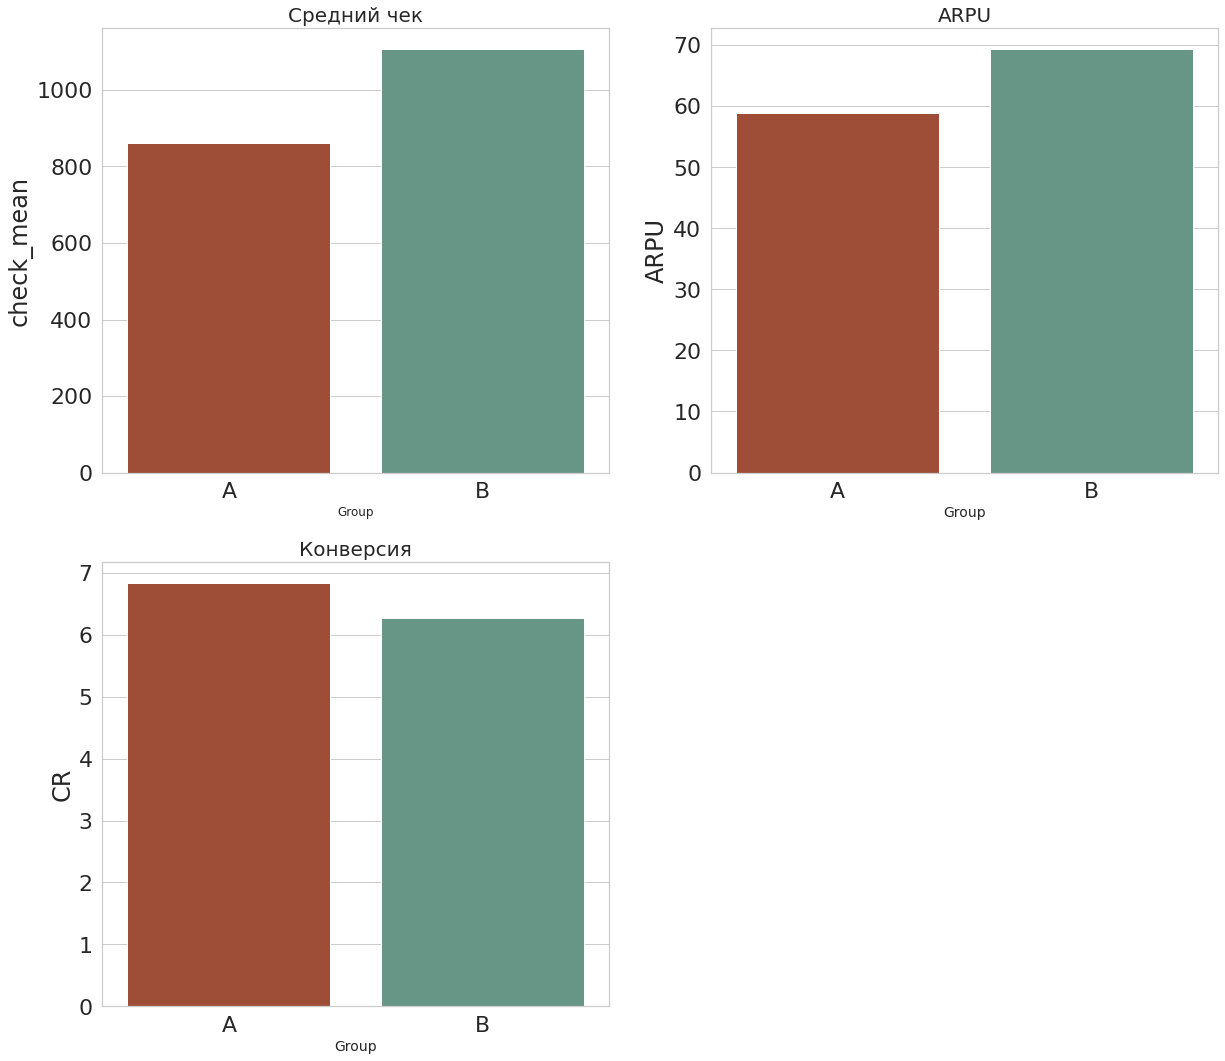

In [55]:
do_visualization(metrics)